In [1]:
import torch
from torchvision.transforms import transforms
import numpy as np

import matplotlib.pyplot as plt
from torchsummary import summary

from models.decoder import DecoderV2
from models.cirtorch_network import init_network, extract_vectors
from models.cirtorch_utils.genericdataset import ImagesFromList

%matplotlib notebook

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
batch_size = 12
resolution = 254
overfit = 2

In [4]:
cir = init_network({'architecture' : 'resnet34'}).to(device)
#dec = DecoderV1(input_size=512, out_res = resolution, start_channels=4, resolution_expansion_factor=6).to(device)
dec = DecoderV2(input_size=512, out_res = resolution, start_res=8).to(device)
summary(cir, (3, resolution, resolution))
summary(dec, (512,), batch_size=1)
if not 'losses' in locals() and not 'losses' in globals():
    losses = []

Down factor: 3.6144080144393795
Initializing model weights
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 127, 127]           9,408
       BatchNorm2d-2         [-1, 64, 127, 127]             128
              ReLU-3         [-1, 64, 127, 127]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 

In [5]:
stats = np.loadtxt('data/img_stats.txt')
normalize = transforms.Normalize(
   mean=stats[0],
   std=stats[1]
)
transform = transforms.Compose([
    transforms.Resize(resolution),
    transforms.CenterCrop(resolution),
    transforms.ToTensor(),
    normalize
])
images = ['db/{}.jpg'.format(i+1) for i in range(overfit)] #4479
dataset = ImagesFromList('data/AachenDayNight/images_upright', images=images, transform=transform, imsize=1024)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = max(overfit, batch_size), shuffle = False, num_workers=4)
print('Using {} image(s) for training'.format(len(dataloader)))

Using 1 image(s) for training


In [6]:
epochs = 300
lr = 1e-3

In [7]:
optim = torch.optim.Adam(list(cir.parameters()) + list(dec.parameters()), lr=lr)
loss_fn = torch.nn.L1Loss(reduction='sum')

In [11]:
cir.train()
dec.train()

for epoch in range(epochs):
    for i, data in enumerate(dataloader):
        data = data.to(device)
        x = cir(data)
        x = dec(x)
        loss = loss_fn(x, data)# Variable(data, requires_grad=False, device=device))
        optim.zero_grad()
        loss.backward()
        optim.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print('\rEpoch: {}\tLoss: {:.8f}'.format(epoch, loss.item()), end='')


Epoch: 290	Loss: 5472.94531250

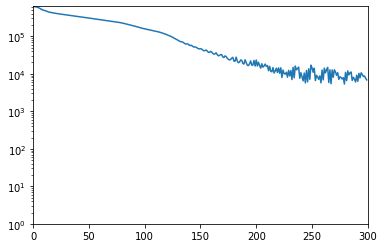

In [9]:
plt.yscale('log')
plt.plot(losses)
plt.xlim(0, len(losses))
plt.ylim(1, max(losses))
plt.show()

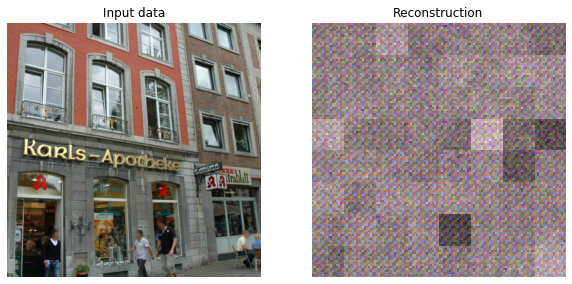

In [10]:
def torch_to_plt(img, stats=None):
    img = img.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
    if stats is not None:
        img = stats[1]*img+stats[0]
    img -= img.min()
    img /= img.max()
    return img

cir.eval()
dec.eval()
test_data = dataset[0]
recon = dec(cir(test_data.unsqueeze(0).to(device)))


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
img = torch_to_plt(test_data, stats)
ax.imshow(img)
ax.axis('off')
ax.set_title('Input data')
ax = fig.add_subplot(1, 2, 2)
img = torch_to_plt(recon, stats=stats)
ax.imshow(img)
ax.axis('off')
ax.set_title('Reconstruction')
plt.show()